# Import Library

In [503]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline 

# Data Preparation

## Load the Data

In [504]:
# Before running this cell make sure "brain_tumor_dataset" zip file is downloaded from:
# https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/brain_tumor_dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Walk through brain_tumor_dataset directory and list number of files
for dirpath, dirnames, filenames in os.walk("brain_tumor_dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 2 directories and 0 files in 'brain_tumor_dataset'.
There are 0 directories and 98 files in 'brain_tumor_dataset/no'.
There are 0 directories and 155 files in 'brain_tumor_dataset/yes'.


In [539]:
# Setup data inputs
data_dir = "/content/brain_tumor_dataset"

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=42,
                                                       batch_size = None)

val_test_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                          validation_split=0.2,
                                                          subset="validation",
                                                          seed=42,
                                                          batch_size = None)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [506]:
# Get class names
class_names = train_ds.class_names
print(f"class names are: {class_names}")

class names are: ['no', 'yes']


In [540]:
# splitting val_test_set so both contains 10% of original data
val_size = int(len(val_test_ds)/2)
test_size = int(len(val_test_ds)/2)

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size).take(test_size)

print(f"Using {len(val_ds)} files for validation")
print(f"Using {len(test_ds)} files for testing")

Using 25 files for validation
Using 25 files for testing


## Data Visualization

In [523]:
# Output info of 3 samples from train_ds dataset
for image, label in train_ds.take(3):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from brain_tumor_dataset (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (256, 256, 3)
  Image dtype: <dtype: 'float32'>
  Target class from brain_tumor_dataset (tensor form): 1
  Class name (str form): yes
        

  Image shape: (256, 256, 3)
  Image dtype: <dtype: 'float32'>
  Target class from brain_tumor_dataset (tensor form): 0
  Class name (str form): no
        

  Image shape: (256, 256, 3)
  Image dtype: <dtype: 'float32'>
  Target class from brain_tumor_dataset (tensor form): 1
  Class name (str form): yes
        


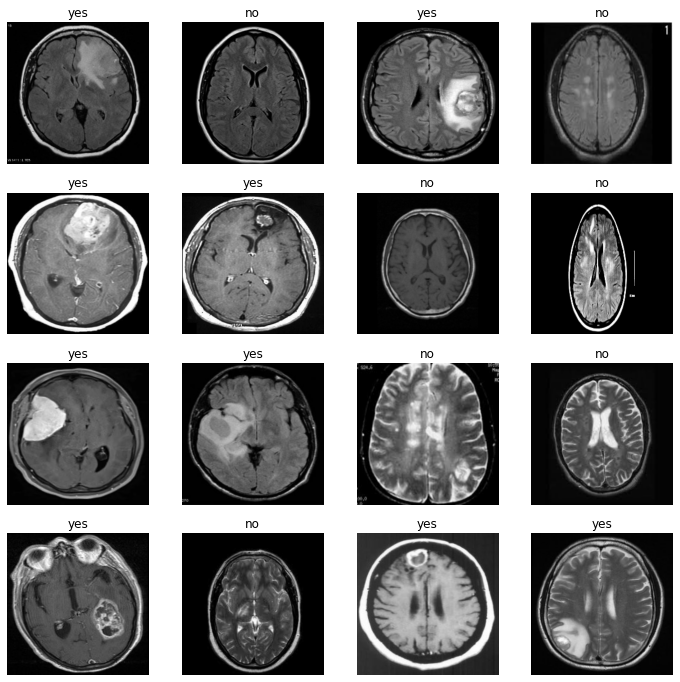

In [509]:
# Visualizing some sample images from training set
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_ds.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image/255.)
  plt.title(class_names[label.numpy()])
  plt.axis("off")

## Preprocessing the Data

In [541]:
# Making a function to preprocess the data
img_size = 256
def preprocess_img(image, label, img_size=img_size):
  """
  reshapes image to (img_size, img_size, color_channels)
  other preprocessing can be added here if needed
  """
  image = tf.image.resize(image, (img_size, img_size))
  return image, label

## Prefetching & Multithread Loading

In [542]:
# Map preprocessing function to datasets and parallelize preprocessing to improve speed
train_ds = train_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Batch, cache, and prefetch the data
batch_size = 4
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [525]:
# Output info of 3 samples after preprocessing, batching, and prefetching
for image, _ in train_ds.take(3):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
        """)


  Image shape: (4, 256, 256, 3)
  Image dtype: <dtype: 'float32'>
        

  Image shape: (4, 256, 256, 3)
  Image dtype: <dtype: 'float32'>
        

  Image shape: (4, 256, 256, 3)
  Image dtype: <dtype: 'float32'>
        


## Data Augmentation

In [513]:
# Create a data augmentation stage with horizontal flipping, rotation, and zoom
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name ="data_augmentation")

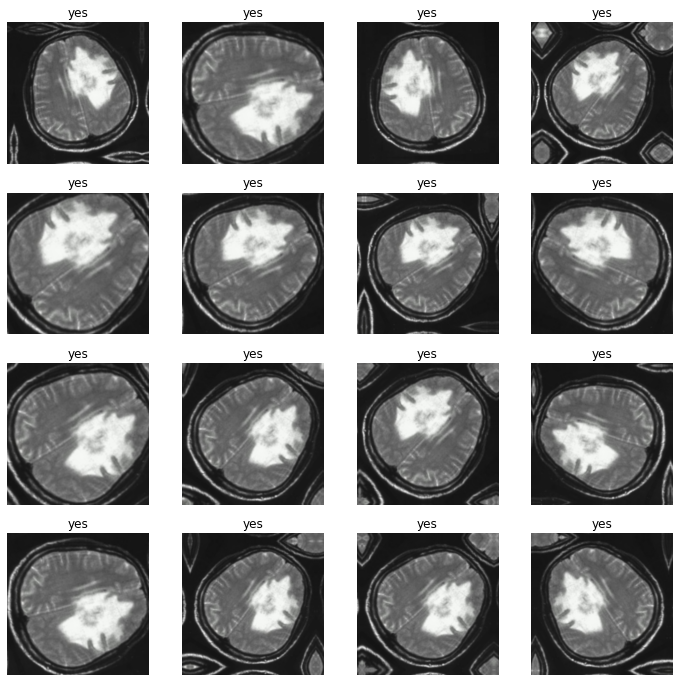

In [514]:
# Visualizing the 1st image of the 1st batch after 16 random augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    image = images[0]
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        aug_img = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.imshow(tf.squeeze(aug_img).numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        plt.axis("off")

# Build a model

Using InceptionV3 model, pretrained on the ImageNet dataset, as base model.

Reference: Rethinking the Inception Architecture for Computer Vision (https://arxiv.org/abs/1512.00567) (CVPR 2016)

## Feature Extraction

In [515]:
# Setup input shape and base model
input_shape = (img_size, img_size, 3)
base_model = keras.applications.InceptionV3(weights="imagenet",
                                           input_shape=input_shape,
                                           include_top=False)
# Freeze the base_model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=input_shape, name="input_layer")

# Apply random data augmentation
x = data_augmentation(inputs)  

# Scaling input to a range of (-1., +1.) from (0, 255) 
x = keras.layers.Rescaling(scale=1/127.5, offset=-1)(x)

# Running the base_model in inference mode so that batchnorm statistics don't get updated even for fine-tuning.
x = base_model(x, training=False)

# Convert outputs of the base model to vectors
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) 

# Add dropout layer to regularize
x = keras.layers.Dropout(0.5)(x)

# Create the output activation layer
outputs = keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 rescaling_35 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0  

In [516]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_feature_extraction = model.fit(train_ds,
                                       epochs=15,
                                       validation_data=val_ds)

Epoch 1/15
41/41 [==============================] - 7s 67ms/step - loss: 0.7230 - accuracy: 0.6108 - val_loss: 0.6530 - val_accuracy: 0.6000
Epoch 2/15
41/41 [==============================] - 1s 35ms/step - loss: 0.5147 - accuracy: 0.7340 - val_loss: 0.6136 - val_accuracy: 0.7200
Epoch 3/15
41/41 [==============================] - 1s 30ms/step - loss: 0.4769 - accuracy: 0.7488 - val_loss: 0.6122 - val_accuracy: 0.7200
Epoch 4/15
41/41 [==============================] - 1s 30ms/step - loss: 0.4705 - accuracy: 0.7635 - val_loss: 0.6681 - val_accuracy: 0.6000
Epoch 5/15
41/41 [==============================] - 1s 30ms/step - loss: 0.4745 - accuracy: 0.7586 - val_loss: 0.6095 - val_accuracy: 0.7200
Epoch 6/15
41/41 [==============================] - 1s 30ms/step - loss: 0.4546 - accuracy: 0.8030 - val_loss: 0.6012 - val_accuracy: 0.7200
Epoch 7/15
41/41 [==============================] - 1s 31ms/step - loss: 0.4185 - accuracy: 0.8177 - val_loss: 0.5845 - val_accuracy: 0.7200
Epoch 8/15
41

## Fine-tuning

In [518]:
# Unfreeze the entire base model
base_model.trainable = True

# Freeze all layers except the last 40 layers
for layer in base_model.layers[:-40]:
  layer.trainable = False

model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 rescaling_35 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_24 (Dropout)        (None, 2048)              0  

In [520]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Fit the model
history_fine_tuning = model.fit(train_ds,
                                epochs=15,
                                validation_data=val_ds)

Epoch 1/15
41/41 [==============================] - 7s 67ms/step - loss: 0.4746 - accuracy: 0.7882 - val_loss: 0.4556 - val_accuracy: 0.8000
Epoch 2/15
41/41 [==============================] - 2s 37ms/step - loss: 0.3099 - accuracy: 0.8473 - val_loss: 0.4041 - val_accuracy: 0.7600
Epoch 3/15
41/41 [==============================] - 1s 35ms/step - loss: 0.2883 - accuracy: 0.8818 - val_loss: 0.3404 - val_accuracy: 0.8400
Epoch 4/15
41/41 [==============================] - 1s 35ms/step - loss: 0.2225 - accuracy: 0.9163 - val_loss: 0.2891 - val_accuracy: 0.8000
Epoch 5/15
41/41 [==============================] - 1s 35ms/step - loss: 0.1835 - accuracy: 0.9310 - val_loss: 0.5400 - val_accuracy: 0.8000
Epoch 6/15
41/41 [==============================] - 1s 35ms/step - loss: 0.2419 - accuracy: 0.8916 - val_loss: 0.3012 - val_accuracy: 0.8000
Epoch 7/15
41/41 [==============================] - 1s 35ms/step - loss: 0.1399 - accuracy: 0.9409 - val_loss: 0.3097 - val_accuracy: 0.8400
Epoch 8/15
41

# Evaluation

## Loss Curves

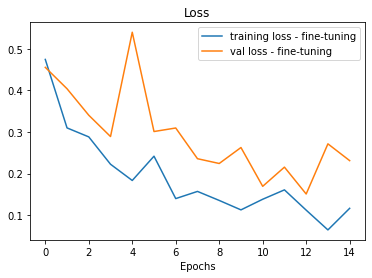

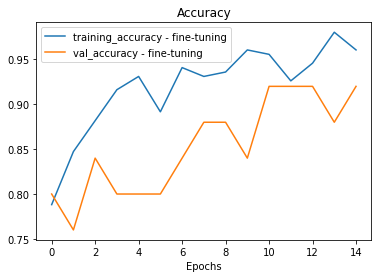

In [526]:
# Accuracy and loss curves of fine-tuned model for training and validation sets 
loss = history_fine_tuning.history['loss']
val_loss = history_fine_tuning.history['val_loss']
accuracy = history_fine_tuning.history['accuracy']
val_accuracy = history_fine_tuning.history['val_accuracy']

epochs = range(len(history_fine_tuning.history['loss']))

# Plot loss
plt.figure()
plt.plot(epochs, loss, label='training loss - fine-tuning')
plt.plot(epochs, val_loss, label='val loss - fine-tuning')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy - fine-tuning')
plt.plot(epochs, val_accuracy, label='val_accuracy - fine-tuning')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

## Evaluation on Test Data

In [543]:
# Evaluate the model on the test data
print("Evaluation on Test data \n")
loss, accuracy = model.evaluate(test_ds)
print(f"\nModel loss on test set: {(loss):.2f}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

Evaluation on Test data 

7/7 [==============================] - 0s 40ms/step - loss: 0.1302 - accuracy: 0.9200

Model loss on test set: 0.13
Model accuracy on test set: 92.00%


## Confusion Matrix & Classification Report

In [544]:
# Model prediction for test data
pred = model.predict(test_ds)

# Match the prediction class to the highest prediction probability
y_pred = [int(np.round(pred[i])[0]) for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = np.concatenate([label for image, label in test_ds], axis=0)
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

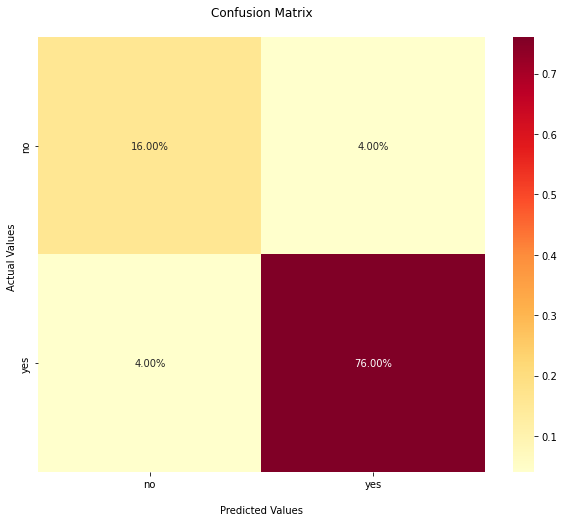

In [545]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

In [538]:
# Classification report
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

          no      0.800     0.800     0.800         5
         yes      0.950     0.950     0.950        20

    accuracy                          0.920        25
   macro avg      0.875     0.875     0.875        25
weighted avg      0.920     0.920     0.920        25



# Summary

By training the top 40 layers of the base model, InceptionV3, an accuracy of  92% is achieved on validation and test sets.